In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
from datetime import datetime
import re
import scipy 
from scipy import stats
sns.set_theme(context = 'talk', style = 'darkgrid')

## Join NHL and Elite datasets 

In [2]:
#load files 
nhl_data = pd.read_csv(r'C:\Users\akobe\OneDrive\Desktop\Lighthouse\After\Predicting_Success_all_Rounds_NHL\Data\NaNs_removed_NHL_all_rounds.csv', index_col = [0]) #index col makes sures another index column is not needed
elite_data =  pd.read_csv(r'C:\Users\akobe\lighthouse-data-notes\Data\all_elite_prospect_data.csv', index_col = [0])

In [3]:
nhl_data.head(2)

draft_year  draft_round  pick_no                 team  prospect_name  \
0        2009            1        1   New York Islanders   John Tavares   
1        2009            1        2  Tampa Bay Lightning  Victor Hedman   

   prospect_id         dob birth_country height  weight shoots   nhl_id  \
0        24111  1990-09-20           CAN  6' 1"     209      L  8475166   
1        33799  1990-12-18           SWE  6' 6"     220      L  8475167   

  position      prospect_category amateur_league amateur_team  \
0        C  North American Skater            OHL       London   
1        D        European Skater         SWEDEN         Modo   

   nhl_games_played  200+games  
0              1029          1  
1               974          1

In [4]:
len(nhl_data)

1867

In [5]:
elite_data.head(2)

elite_id     elite_name   nhl_id  draft_year draft_season  prospect_gp  \
0      9223   John Tavares  8475166        2009    2008-2009           56   
1      6007  Victor Hedman  8475167        2009    2008-2009           45   

   prospect_g  prospect_a  prospect_pts  prospect_pim  prospect_pm  
0          58          46           104            54           10  
1           7          16            23            62           21

In [8]:
len(elite_data)

1842

In [7]:
#removes duplicate names 
elite_data = elite_data.drop_duplicates(subset = ['elite_name'], keep='first')

In [9]:
#join the datasets on nhl_id
data = pd.merge(elite_data, nhl_data, how="left", on = 'nhl_id')

In [10]:
data.head(2)

elite_id     elite_name   nhl_id  draft_year_x draft_season  prospect_gp  \
0      9223   John Tavares  8475166          2009    2008-2009           56   
1      6007  Victor Hedman  8475167          2009    2008-2009           45   

   prospect_g  prospect_a  prospect_pts  prospect_pim  ...  birth_country  \
0          58          46           104            54  ...            CAN   
1           7          16            23            62  ...            SWE   

   height  weight  shoots position      prospect_category  amateur_league  \
0   6' 1"     209       L        C  North American Skater             OHL   
1   6' 6"     220       L        D        European Skater          SWEDEN   

  amateur_team nhl_games_played 200+games  
0       London             1029         1  
1         Modo              974         1  

[2 rows x 28 columns]

In [11]:
len(data)

1857

In [12]:
data.columns.values.tolist() 

['elite_id',
 'elite_name',
 'nhl_id',
 'draft_year_x',
 'draft_season',
 'prospect_gp',
 'prospect_g',
 'prospect_a',
 'prospect_pts',
 'prospect_pim',
 'prospect_pm',
 'draft_year_y',
 'draft_round',
 'pick_no',
 'team',
 'prospect_name',
 'prospect_id',
 'dob',
 'birth_country',
 'height',
 'weight',
 'shoots',
 'position',
 'prospect_category',
 'amateur_league',
 'amateur_team',
 'nhl_games_played',
 '200+games']

In [13]:
#drop unwanted columns and columns that are duplicates of each other 
data = data.drop(['draft_year_y', 'prospect_name', 'prospect_id'], axis=1)

In [14]:
#rename columns 
data.rename(columns = {'draft_year_x':'draft_year', 'elite_name': 'name'}, inplace = True)

In [15]:
#convert dob to date, extract out the year, month, day 
data['dob'] = pd.to_datetime(data['dob'])
data['birth_year']= data['dob'].dt.year
data['birth_month']= data['dob'].dt.month
data['birth_day']= data['dob'].dt.day

In [16]:
#splits height column into feet and inches 
data[['feet', 'inches']] = data["height"].apply(lambda x: pd.Series(str(x).split("'")))
#removes quotes from the end of the inches column
data['inches'] = data['inches'].apply(lambda x: pd.Series(str(x).replace('"', "")))

In [17]:
#converts feet to inches 
data['feet_in_inches'] = data['feet'].apply(lambda x: int(x)*12)

#gives a height in inches 
data['total_inches'] = data.apply(lambda x: int(x['feet_in_inches']) + int(x['inches']), axis=1)

#gives height in cm 
data['height_cm'] = data['total_inches'].apply(lambda x: int(x) * 2.54)

#drop intermediate height columns 
data = data.drop(['feet', 'inches', 'feet_in_inches', 'total_inches'], axis=1)

In [18]:
data.head(2)

elite_id           name   nhl_id  draft_year draft_season  prospect_gp  \
0      9223   John Tavares  8475166        2009    2008-2009           56   
1      6007  Victor Hedman  8475167        2009    2008-2009           45   

   prospect_g  prospect_a  prospect_pts  prospect_pim  ...  position  \
0          58          46           104            54  ...         C   
1           7          16            23            62  ...         D   

       prospect_category  amateur_league amateur_team nhl_games_played  \
0  North American Skater             OHL       London             1029   
1        European Skater          SWEDEN         Modo              974   

  200+games birth_year  birth_month birth_day height_cm  
0         1       1990            9        20    185.42  
1         1       1990           12        18    198.12  

[2 rows x 29 columns]

6960

In [19]:
#save the data to csv 
data.to_csv('all_merged_data.csv')

## EDA 

In [20]:
data =  pd.read_csv(r'C:\Users\akobe\lighthouse-data-notes\Data\all_merged_data.csv', index_col = [0])

In [21]:
data.describe()

elite_id        nhl_id   draft_year  prospect_gp   prospect_g  \
count    1857.000000  1.857000e+03  1857.000000  1857.000000  1857.000000   
mean   138992.544965  8.477885e+06  2013.502962    56.486807    16.540118   
std    103685.474027  1.796576e+03     2.876427    13.985598    12.193113   
min      4996.000000  8.474695e+06  2009.000000     0.000000     0.000000   
25%     40249.000000  8.476379e+06  2011.000000    48.000000     7.000000   
50%    117000.000000  8.477573e+06  2014.000000    58.000000    14.000000   
75%    226444.000000  8.479421e+06  2016.000000    66.000000    24.000000   
max    484201.000000  8.481085e+06  2018.000000    96.000000    87.000000   

        prospect_a  prospect_pts  prospect_pim  prospect_pm  draft_round  \
count  1857.000000   1857.000000   1857.000000  1857.000000  1857.000000   
mean     26.107162     42.647281     49.295100     6.547119     3.915994   
std      15.062150     24.913341     36.829043    15.852263     2.022089   
min       0.000000      0.000000      0.000000   -72.000000     1.000000   
25%      15.000000     23.000000     23.000000    -1.000000     2.000000   
50%      24.000000     39.000000     41.000000     4.000000     4.000000   
75%      35.000000     58.000000     66.000000    15.000000     6.000000   
max      94.000000    159.000000    334.000000    69.000000     7.000000   

           pick_no      weight  nhl_games_played    200+games   birth_year  \
count  1857.000000  1857.00000       1857.000000  1857.000000  1857.000000   
mean    104.110393   193.00377        120.437264     0.220248  1995.026387   
std      61.902368    15.32041        205.548647     0.414525     2.960562   
min       1.000000   139.00000          0.000000     0.000000  1989.000000   
25%      49.000000   183.00000          0.000000     0.000000  1993.000000   
50%     103.000000   192.00000          1.000000     0.000000  1995.000000   
75%     157.000000   203.00000        163.000000     0.000000  1998.000000   
max     217.000000   259.00000       1029.000000     1.000000  2000.000000   

       birth_month    birth_day    height_cm  
count  1857.000000  1857.000000  1857.000000  
mean      5.480345    15.459882   185.597814  
std       3.305847     8.794139     5.436611  
min       1.000000     1.000000   167.640000  
25%       3.000000     8.000000   182.880000  
50%       5.000000    15.000000   185.420000  
75%       8.000000    23.000000   187.960000  
max      12.000000    31.000000   205.740000

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1857 entries, 0 to 1856
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   elite_id           1857 non-null   int64  
 1   name               1857 non-null   object 
 2   nhl_id             1857 non-null   int64  
 3   draft_year         1857 non-null   int64  
 4   draft_season       1857 non-null   object 
 5   prospect_gp        1857 non-null   int64  
 6   prospect_g         1857 non-null   int64  
 7   prospect_a         1857 non-null   int64  
 8   prospect_pts       1857 non-null   int64  
 9   prospect_pim       1857 non-null   int64  
 10  prospect_pm        1857 non-null   int64  
 11  draft_round        1857 non-null   int64  
 12  pick_no            1857 non-null   int64  
 13  team               1857 non-null   object 
 14  dob                1857 non-null   object 
 15  birth_country      1857 non-null   object 
 16  height             1857 

<AxesSubplot:xlabel='200+games', ylabel='count'>

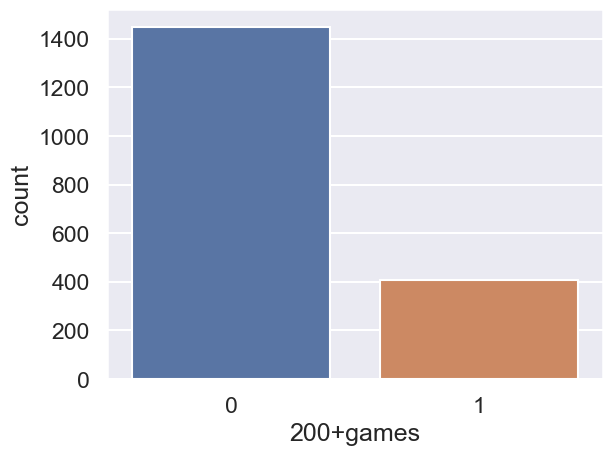

In [23]:
#plot of players with 200+ games and <200 games --> 200+ is th 1
sns.countplot(x ='200+games', data = data) 

In [24]:
#data dount, for calculating percentages 
data_count = 1857

In [25]:
#displays the count and percentage of players based on games played 
less200 = data['200+games'].value_counts()[0]
plus200 = data['200+games'].value_counts()[1]
perc_less200 = round((less200/data_count)*100, 2)
perc_plus200 = round((plus200/data_count)*100, 2)
print(f'{less200} played <200 NHL games, {perc_less200}% of players') 
print(f'{plus200} played 200+ NHL games, {perc_plus200}% of players') 

1448 played <200 NHL games, 77.98% of players
409 played 200+ NHL games, 22.02% of players


<AxesSubplot:xlabel='birth_month', ylabel='count'>

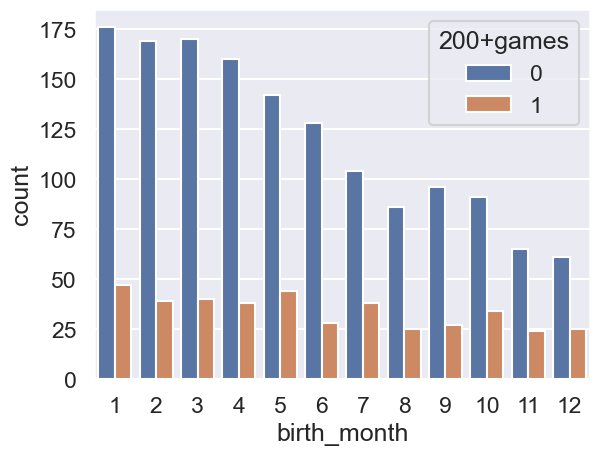

In [26]:
sns.countplot(x = data['birth_month'], hue = data['200+games'])

<AxesSubplot:xlabel='birth_month', ylabel='count'>

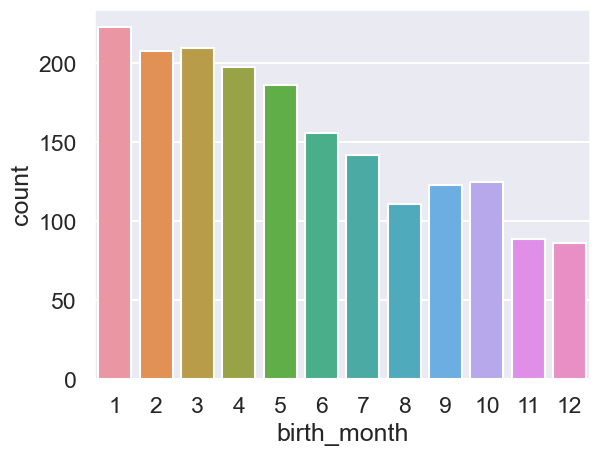

In [27]:
sns.countplot(x = data['birth_month'])

<AxesSubplot:xlabel='birth_country', ylabel='count'>

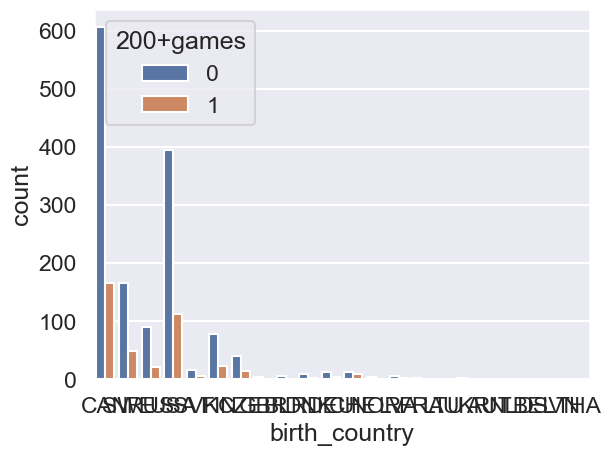

In [28]:
#birth country 
sns.countplot(x = data['birth_country'], hue = data['200+games'])

In [29]:
data['birth_country']. unique() 

array(['CAN', 'SWE', 'RUS', 'USA', 'SVK', 'FIN', 'CZE', 'GBR', 'BLR',
       'DNK', 'DEU', 'CHE', 'NOR', 'LVA', 'FRA', 'LTU', 'UKR', 'AUT',
       'NLD', 'BEL', 'SVN', 'THA'], dtype=object)

In [30]:
#games playe by country count 
data.groupby('birth_country')['200+games'].value_counts()

birth_country  200+games
AUT            0              1
               1              1
BEL            0              1
BLR            0              6
               1              1
CAN            0            606
               1            166
CHE            0             13
               1              8
CZE            0             39
               1             14
DEU            0             12
               1              3
DNK            0              8
               1              2
FIN            0             78
               1             23
FRA            0              2
GBR            0              4
               1              1
LTU            0              1
LVA            0              6
               1              2
NLD            1              1
NOR            0              3
RUS            0             89
               1             21
SVK            0             15
               1              5
SVN            0              1
SWE            

<AxesSubplot:xlabel='shoots', ylabel='count'>

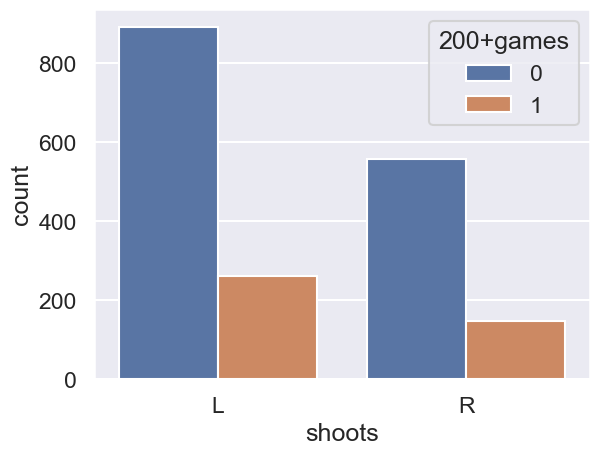

In [31]:
#shoots
sns.countplot(x = data['shoots'], hue = data['200+games'])

In [32]:
data.groupby('shoots')['200+games'].value_counts()

shoots  200+games
L       0            891
        1            261
R       0            557
        1            148
Name: 200+games, dtype: int64

<AxesSubplot:xlabel='position', ylabel='count'>

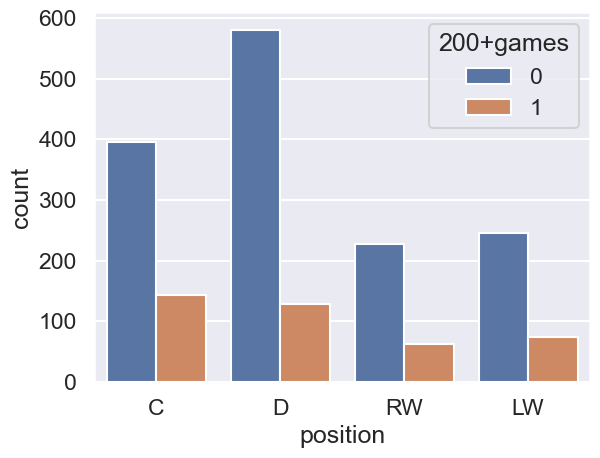

In [33]:
#position
sns.countplot(x = data['position'], hue = data['200+games'])

In [34]:
data.groupby('position')['200+games'].value_counts()

position  200+games
C         0            395
          1            144
D         0            580
          1            129
LW        0            245
          1             74
RW        0            228
          1             62
Name: 200+games, dtype: int64

<AxesSubplot:xlabel='prospect_category', ylabel='count'>

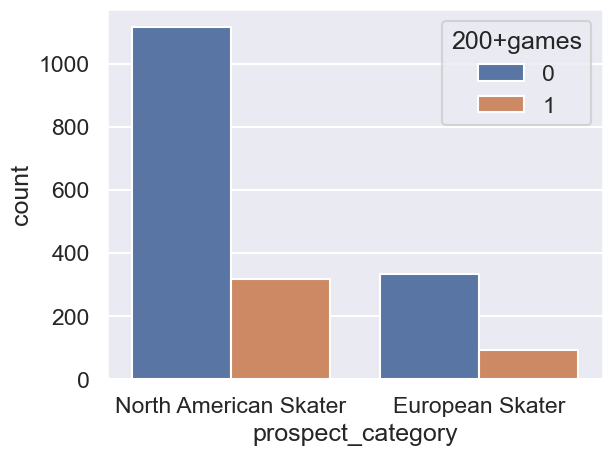

In [35]:
#prospect_category
sns.countplot(x = data['prospect_category'], hue = data['200+games'])

In [36]:
data.groupby('prospect_category')['200+games'].value_counts()

prospect_category      200+games
European Skater        0             332
                       1              92
North American Skater  0            1116
                       1             317
Name: 200+games, dtype: int64

<AxesSubplot:xlabel='amateur_league', ylabel='count'>

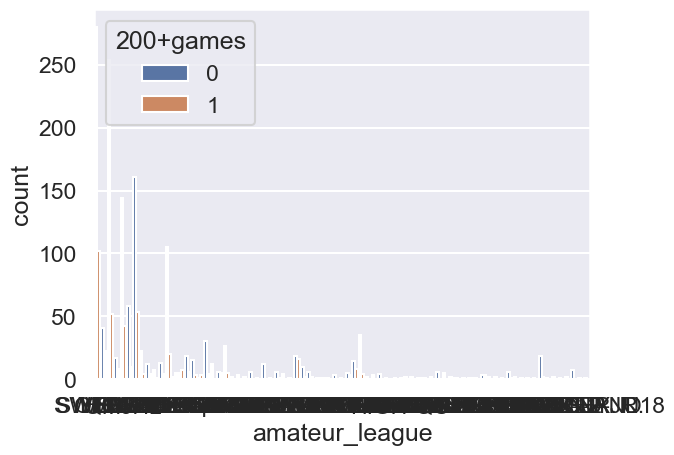

In [37]:
#amateur_league 
sns.countplot(x = data['amateur_league'], hue = data['200+games'])

In [38]:
data.groupby('amateur_league')['200+games'].value_counts()

amateur_league  200+games
AHL             0              1
AJHL            0             13
                1              4
BCHL            0             26
                1              5
                            ... 
USPHL PRE.      1              1
WCHA            0             12
                1              4
WHL             0            254
                1             52
Name: 200+games, Length: 111, dtype: int64

In [39]:
data.value_counts('amateur_league')

amateur_league
OHL           382
WHL           306
USHL          214
QMJHL         186
SWEDEN-JR.    125
             ... 
HIGH-NY         1
MWEHL           1
HIGH-QC         1
MIDGET          1
AHL             1
Length: 77, dtype: int64

In [40]:
#drop data not wanted for further stats 
data_stats = data.drop(['nhl_id', 'elite_id', 'name', 'draft_year', 'draft_season', 'pick_no', 'team', 'amateur_team',
                       'nhl_games_played', 'height'], axis=1)

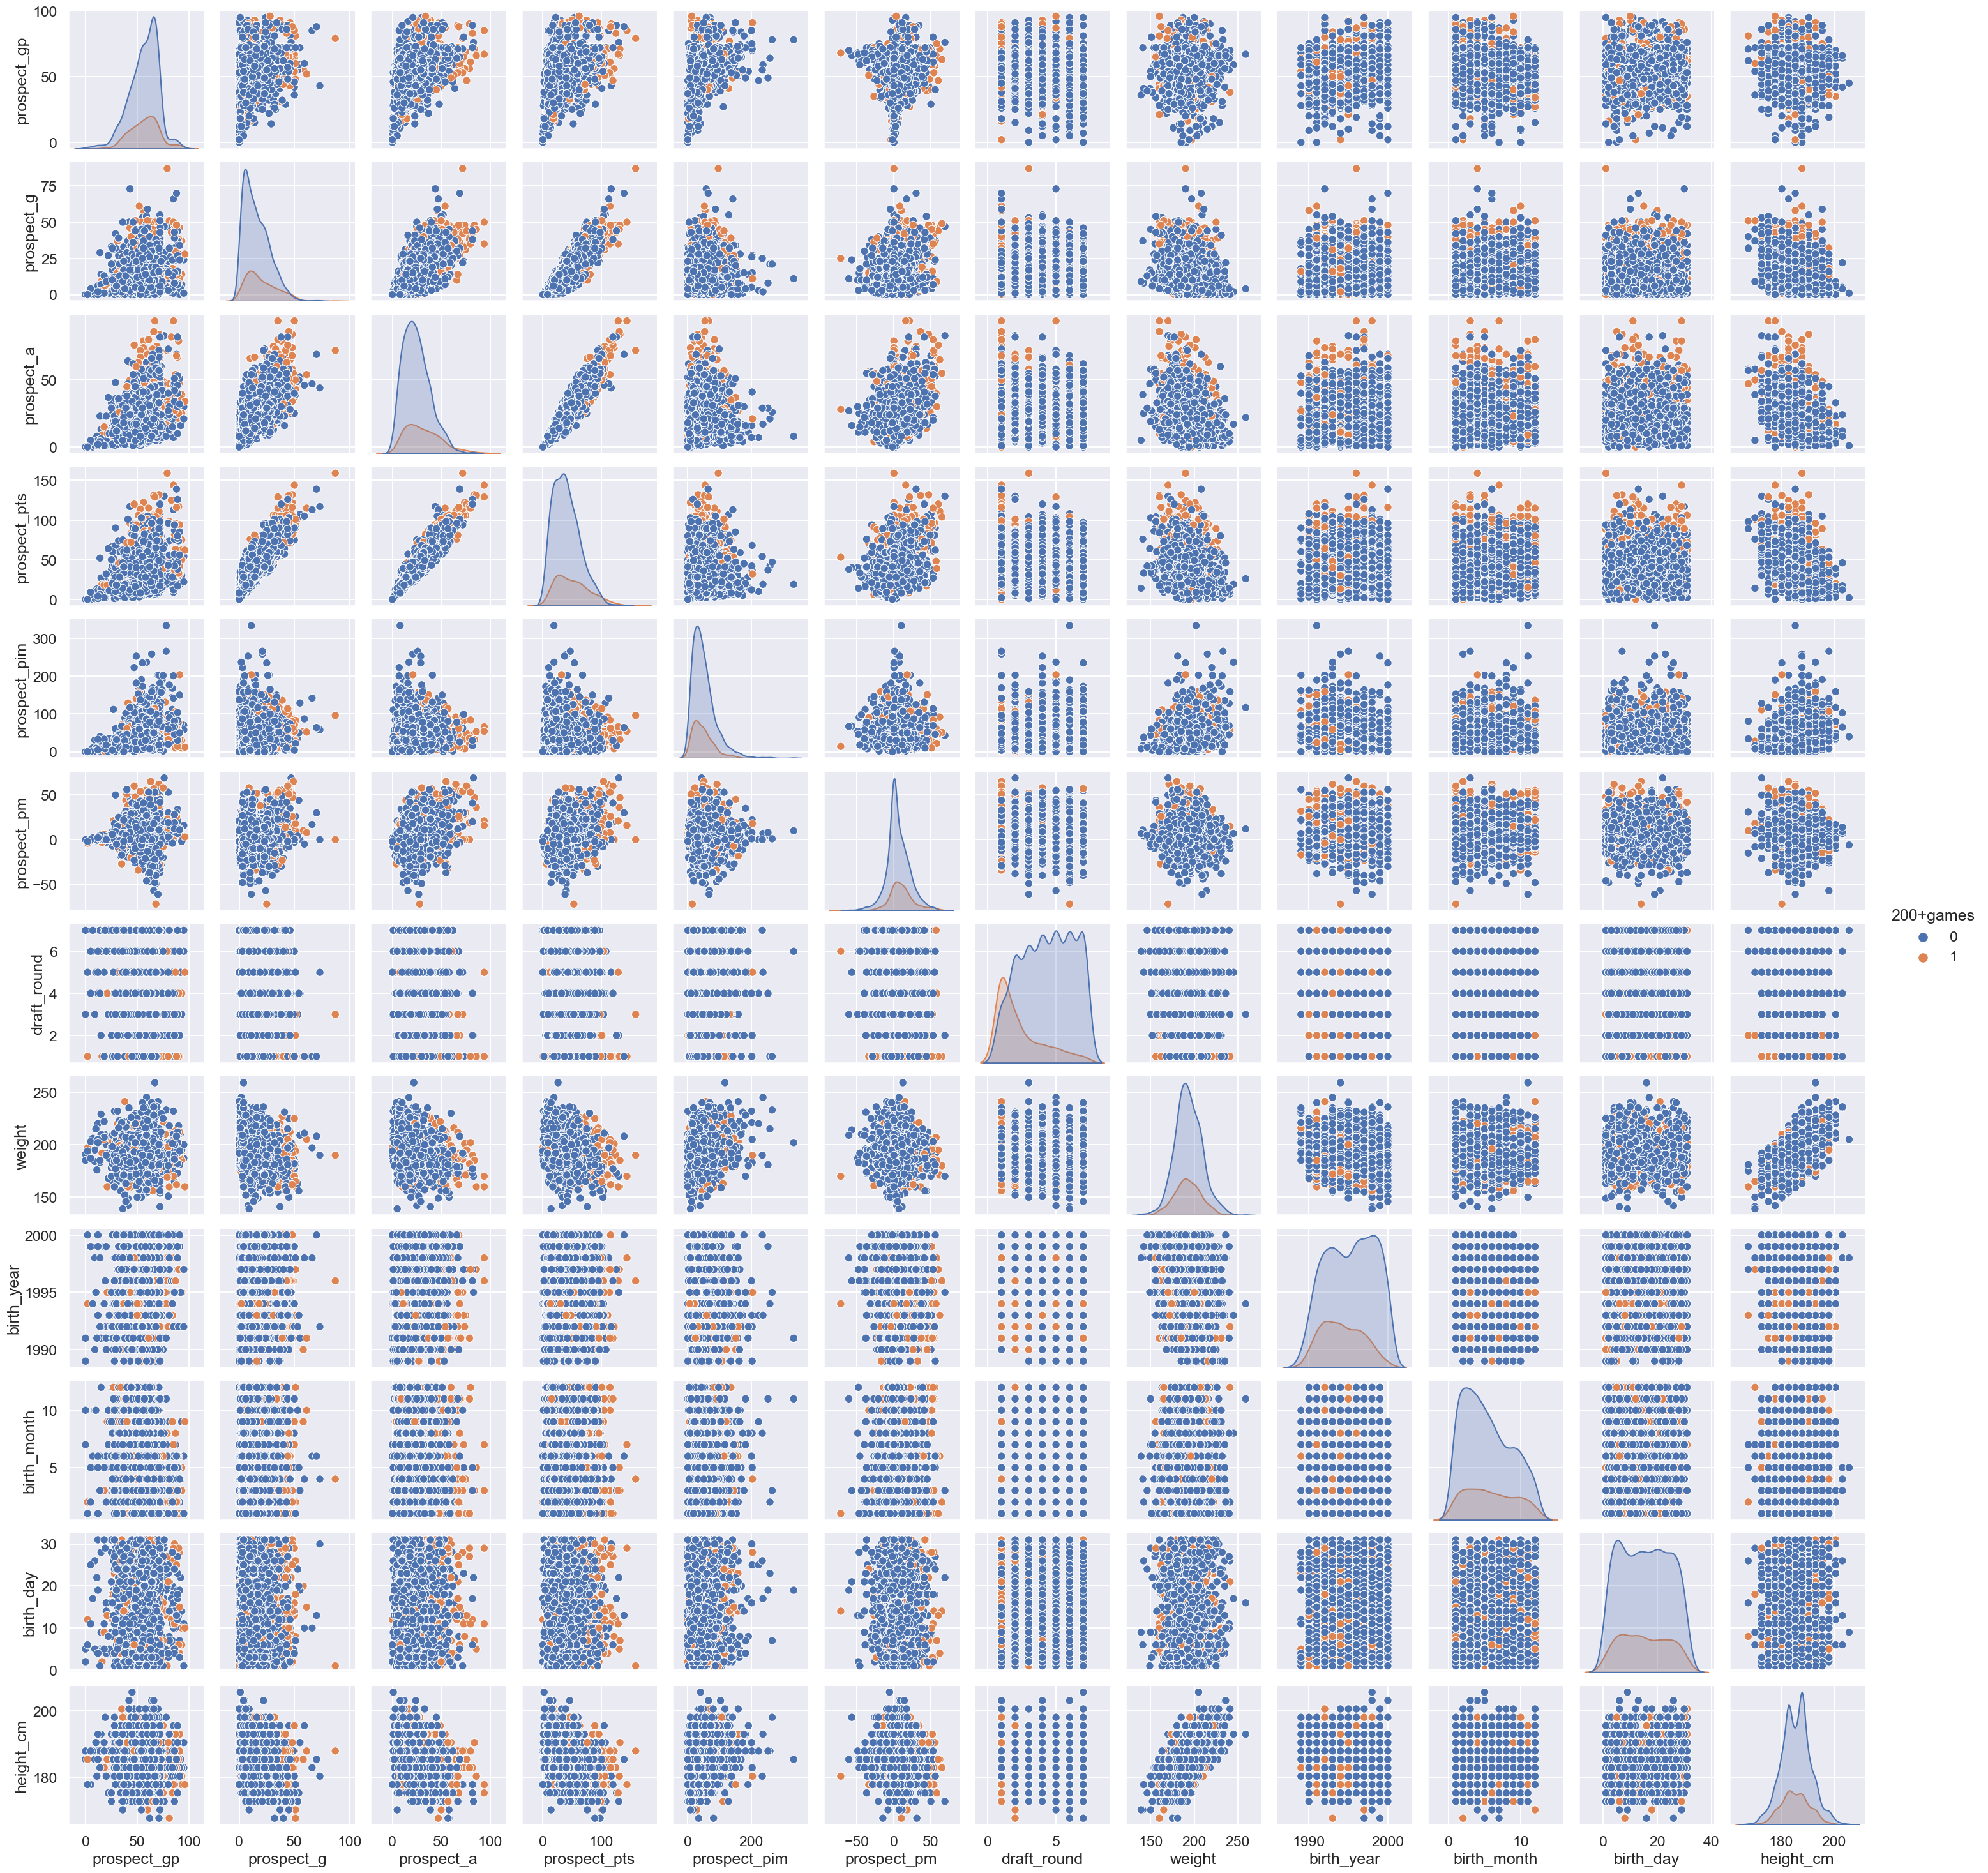

In [41]:
#pairplot 
sns.pairplot(data_stats, hue='200+games')

<AxesSubplot:>

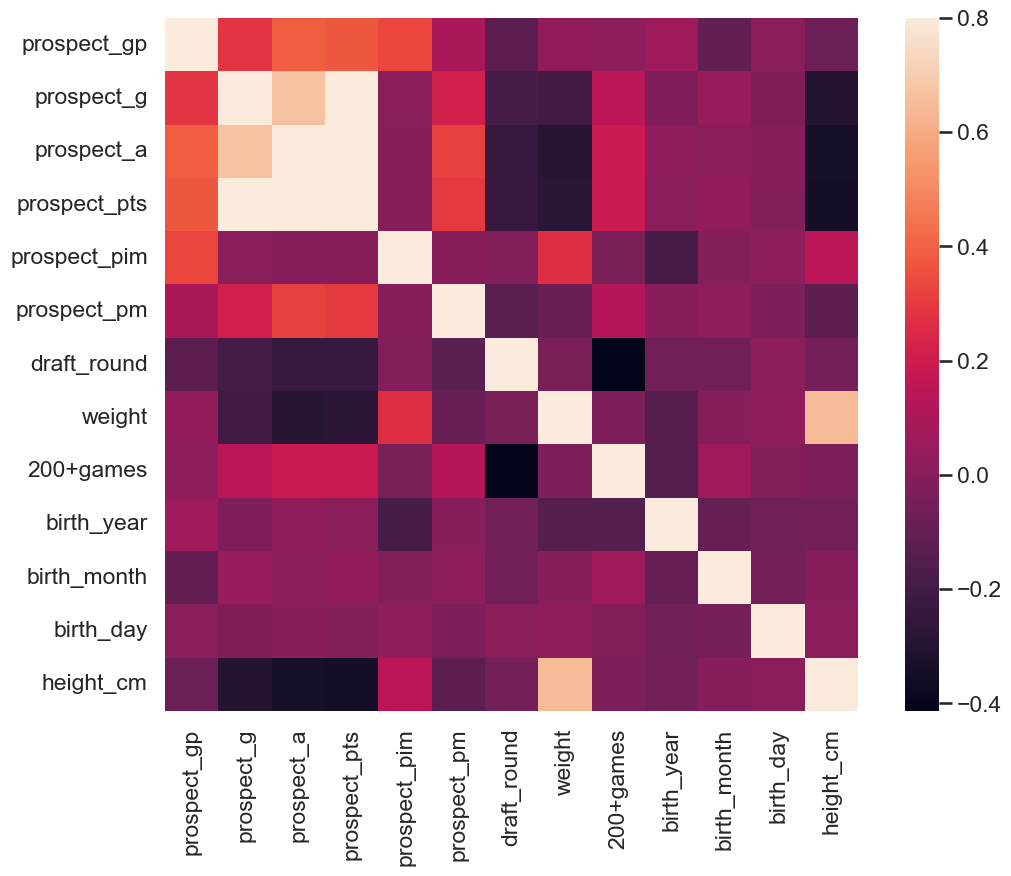

In [42]:
# correlation matrix
corrmat = data_stats.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

<AxesSubplot:xlabel='prospect_gp', ylabel='Count'>

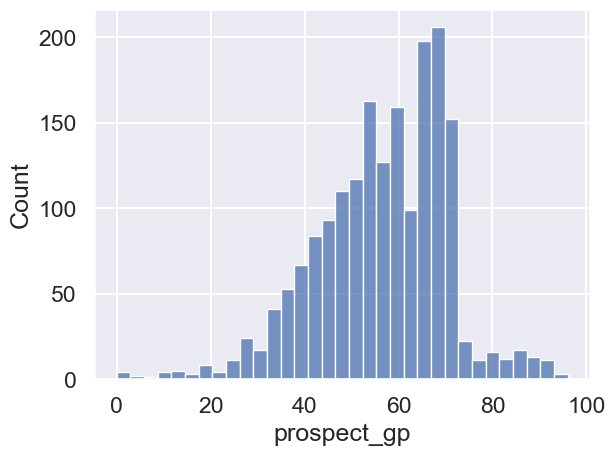

In [43]:
#histogram GP
sns.histplot(data_stats, x="prospect_gp")

<AxesSubplot:xlabel='prospect_g', ylabel='Count'>

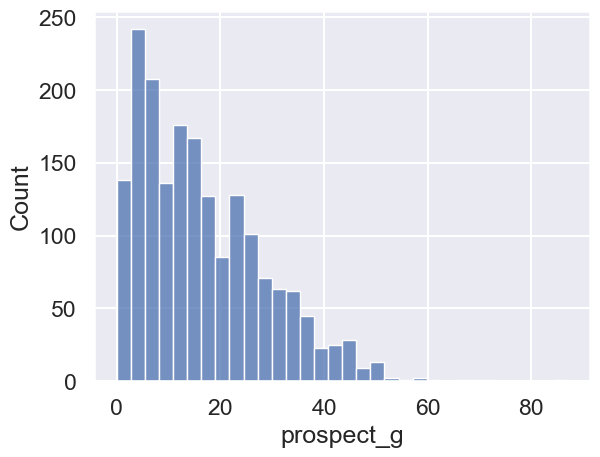

In [44]:
#histogram goals 
sns.histplot(data=data_stats, x="prospect_g")

<AxesSubplot:xlabel='prospect_a', ylabel='Count'>

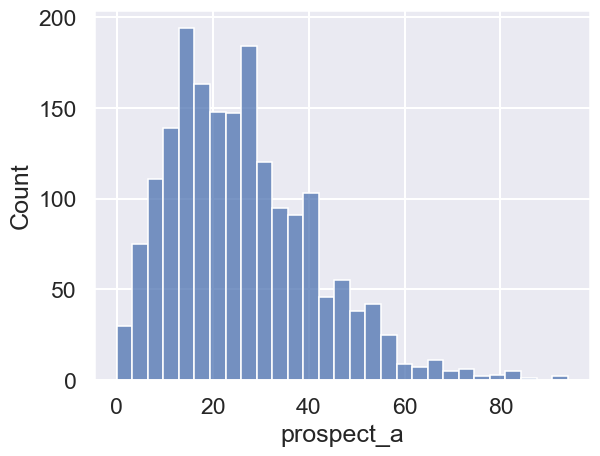

In [45]:
# histogram assists 
sns.histplot(data=data_stats, x="prospect_a")

<AxesSubplot:xlabel='prospect_pim', ylabel='Count'>

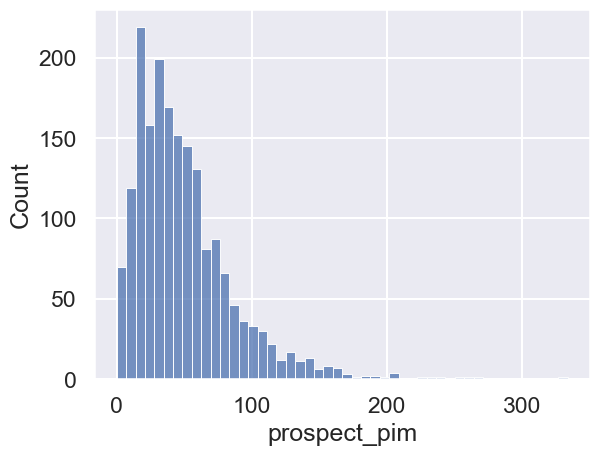

In [46]:
#histogram pim
sns.histplot(data=data_stats, x="prospect_pim")

<AxesSubplot:xlabel='prospect_pm', ylabel='Count'>

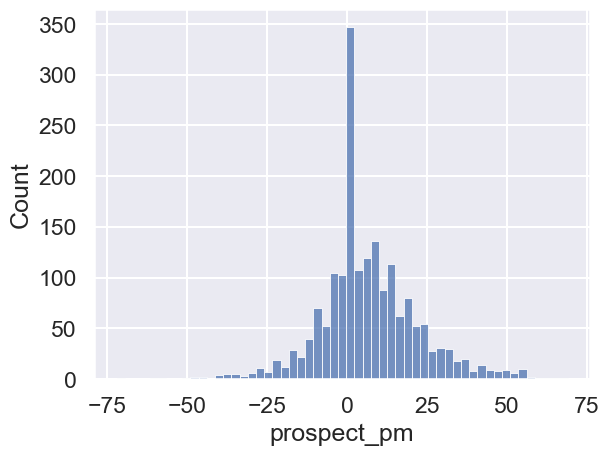

In [47]:
#histogram pm 
sns.histplot(data=data_stats, x="prospect_pm")

<AxesSubplot:xlabel='height_cm', ylabel='Count'>

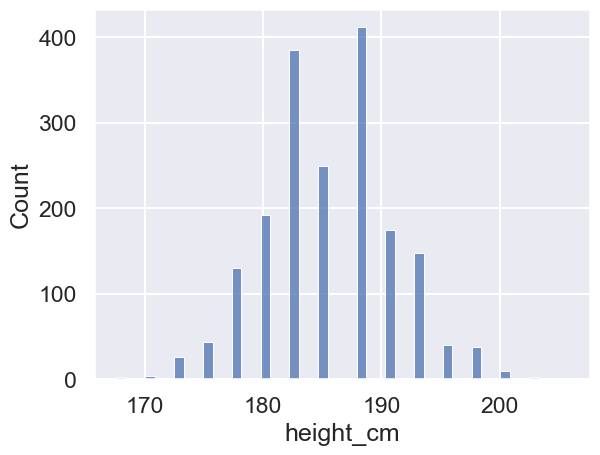

In [48]:
#histogram height cm 
sns.histplot(data=data_stats, x="height_cm")

<AxesSubplot:xlabel='weight', ylabel='Count'>

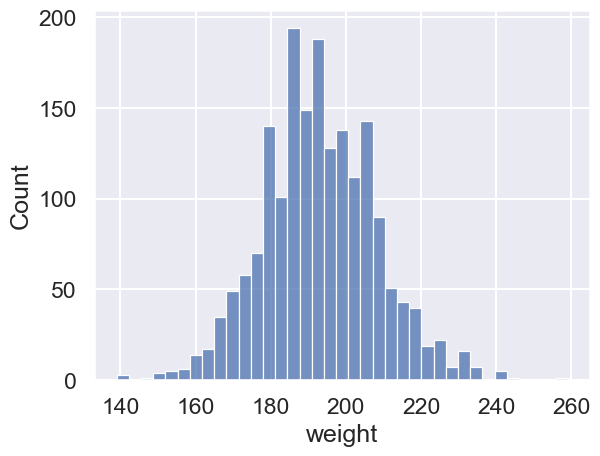

In [49]:
#histogram weight 
sns.histplot(data=data_stats, x="weight")

In [50]:
#games vs brith country 
contingency = pd.crosstab(data_stats['200+games'], data_stats['birth_country'])
contingency

birth_country  AUT  BEL  BLR  CAN  CHE  CZE  DEU  DNK  FIN  FRA  ...  LVA  \
200+games                                                        ...        
0                1    1    6  606   13   39   12    8   78    2  ...    6   
1                1    0    1  166    8   14    3    2   23    0  ...    2   

birth_country  NLD  NOR  RUS  SVK  SVN  SWE  THA  UKR  USA  
200+games                                                   
0                0    3   89   15    1  165    1    2  395  
1                1    0   21    5    0   49    0    0  112  

[2 rows x 22 columns]

In [51]:
#games vs brith country 
stat, p, dof, expected = stats.chi2_contingency(contingency)
print(f'stat = {stat}, p = {p}, dof= {dof}, expected = {expected}')

stat = 12.57453740073927, p = 0.9227943423508094, dof= 21, expected = [[1.55950458e+00 7.79752289e-01 5.45826602e+00 6.01968767e+02
  1.63747981e+01 4.13268713e+01 1.16962843e+01 7.79752289e+00
  7.87549812e+01 1.55950458e+00 3.89876144e+00 7.79752289e-01
  6.23801831e+00 7.79752289e-01 2.33925687e+00 8.57727518e+01
  1.55950458e+01 7.79752289e-01 1.66866990e+02 7.79752289e-01
  1.55950458e+00 3.95334410e+02]
 [4.40495423e-01 2.20247711e-01 1.54173398e+00 1.70031233e+02
  4.62520194e+00 1.16731287e+01 3.30371567e+00 2.20247711e+00
  2.22450188e+01 4.40495423e-01 1.10123856e+00 2.20247711e-01
  1.76198169e+00 2.20247711e-01 6.60743134e-01 2.42272482e+01
  4.40495423e+00 2.20247711e-01 4.71330102e+01 2.20247711e-01
  4.40495423e-01 1.11665590e+02]]


In [52]:
# games vs shoots 
contingency = pd.crosstab(data_stats['200+games'], data_stats['shoots'])
contingency

shoots       L    R
200+games          
0          891  557
1          261  148

In [53]:
#games vs shoots 
stat, p, dof, expected = stats.chi2_contingency(contingency)
print(f'stat = {stat}, p = {p}, dof= {dof}')

stat = 0.6110464733836313, p = 0.43439406629688915, dof= 1


In [54]:
# games vs position
contingency = pd.crosstab(data_stats['200+games'], data_stats['position'])
contingency

position     C    D   LW   RW
200+games                    
0          395  580  245  228
1          144  129   74   62

In [55]:
#games vs position
stat, p, dof, expected = stats.chi2_contingency(contingency)
print(f'stat = {stat}, p = {p}, dof= {dof}')

stat = 13.289563260701007, p = 0.004050471994289679, dof= 3


In [56]:
# games vs birth month 
contingency = pd.crosstab(data_stats['200+games'], data_stats['birth_month'])
contingency

birth_month   1    2    3    4    5    6    7   8   9   10  11  12
200+games                                                         
0            176  169  170  160  142  128  104  86  96  91  65  61
1             47   39   40   38   44   28   38  25  27  34  24  25

In [57]:
# games vs prospect category 
contingency = pd.crosstab(data_stats['200+games'], data_stats['prospect_category'])
contingency

prospect_category  European Skater  North American Skater
200+games                                                
0                              332                   1116
1                               92                    317

In [58]:
#games vs category
stat, p, dof, expected = stats.chi2_contingency(contingency)
print(f'stat = {stat}, p = {p}, dof= {dof}')

stat = 0.013939506660453953, p = 0.9060156103406197, dof= 1


In [59]:
# games vs amateur league 
contingency = pd.crosstab(data_stats['200+games'], data_stats['amateur_league'])
contingency

amateur_league  AHL  AJHL  BCHL  BIG10  BLR JR.  CCHA  CCHL  CHL  CJHL  CZECH  \
200+games                                                                       
0                 1    13    26      3        1     6     6    1     3      0   
1                 0     4     5      3        0     5     2    0     0      1   

amateur_league  ...  SWISS-JR.  US EAST  US WEST  USDP  USHL  USMAAA  USMAAAE  \
200+games       ...                                                             
0               ...          2        1        1     7   161       1        2   
1               ...          0        0        0     1    53       0        0   

amateur_league  USPHL PRE.  WCHA  WHL  
200+games                              
0                        1    12  254  
1                        1     4   52  

[2 rows x 77 columns]

In [60]:
#games vs amateur league 
stat, p, dof, expected = stats.chi2_contingency(contingency)
print(f'stat = {stat}, p = {p}, dof= {dof}')

stat = 123.88758060405857, p = 0.00043335798152970803, dof= 76


In [61]:
import statsmodels.api as sm

X_logreg = data_stats[['prospect_gp', 'prospect_g', 'prospect_a', 'prospect_pim', 'prospect_pm', 'weight', 'birth_month', 'height_cm' ]]
y_logreg = data_stats[['200+games']]

log_reg = sm.Logit(y_logreg, X_logreg).fit()

Optimization terminated successfully.
         Current function value: 0.504075
         Iterations 5


In [62]:
# printing the summary table
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:              200+games   No. Observations:                 1857
Model:                          Logit   Df Residuals:                     1849
Method:                           MLE   Df Model:                            7
Date:                Fri, 28 Apr 2023   Pseudo R-squ.:                 0.04390
Time:                        13:08:27   Log-Likelihood:                -936.07
converged:                       True   LL-Null:                       -979.05
Covariance Type:            nonrobust   LLR p-value:                 8.323e-16
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
prospect_gp     -0.0107      0.005     -2.200      0.028      -0.020      -0.001
prospect_g       0.0065      0.006      1.089      0.276      -0.005       0.018
prospect_a       0.0255      0.005      4.77